In [63]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import learning_curve
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression # Importing LinearRegression

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
X_train = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/X_train.csv', index_col='cut_index')
y_train = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/y_train.csv')
y_train.set_index(X_train.index.values, inplace=True)
X_test = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/X_test.csv', index_col='cut_index')
y_test = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/y_test.csv')
y_test.set_index(X_test.index.values, inplace=True)

In [65]:
X_train['flute_1_lag1'] = y_train['flute_1'].shift(1).bfill()#fillna(method='bfill')
X_train['flute_1_lag2'] = y_train['flute_1'].shift(2).bfill()
X_train['flute_1_lag3'] = y_train['flute_1'].shift(3).bfill()

X_train['flute_2_lag1'] = y_train['flute_2'].shift(1).bfill()
X_train['flute_2_lag2'] = y_train['flute_2'].shift(2).bfill()
X_train['flute_2_lag3'] = y_train['flute_2'].shift(3).bfill()

X_train['flute_3_lag1'] = y_train['flute_3'].shift(1).bfill()
X_train['flute_3_lag2'] = y_train['flute_3'].shift(2).bfill()
X_train['flute_3_lag3'] = y_train['flute_3'].shift(3).bfill()

X_test['flute_1_lag1'] = y_test['flute_1'].shift(1).bfill()
X_test['flute_1_lag2'] = y_test['flute_1'].shift(2).bfill()
X_test['flute_1_lag3'] = y_test['flute_1'].shift(3).bfill()

X_test['flute_2_lag1'] = y_test['flute_2'].shift(1).bfill()
X_test['flute_2_lag2'] = y_test['flute_2'].shift(2).bfill()
X_test['flute_2_lag3'] = y_test['flute_2'].shift(3).bfill()

X_test['flute_3_lag1'] = y_test['flute_3'].shift(1).bfill()
X_test['flute_3_lag2'] = y_test['flute_3'].shift(2).bfill()
X_test['flute_3_lag3'] = y_test['flute_3'].shift(3).bfill()

In [66]:
# Ferramenta 1
X_train_C1 = X_train.iloc[:315, :]
y_train_C1 = y_train.iloc[:315, :]

# Ferramenta 2
X_train_C2 = X_train.iloc[315:, :]
y_train_C2 = y_train.iloc[315:, :]

# Ferramenta 3
X_test_C6 = X_test.iloc[:315, :]
y_test_C6 = y_test.iloc[:315, :]

## SGD com 25% das features (12 features)

In [ ]:
# Passo 1: Aplicando o RFE fora do GridSearch
# Definindo o modelo base para o RFE (sem regularização)
rfe_estimator = LinearRegression()

# Selecionando o número desejado de features com RFE para C1 e C2
n_features_to_select = 12  # Defina o número de features a serem selecionadas

rfe_C1 = RFE(estimator=rfe_estimator, n_features_to_select=n_features_to_select)
X_train_C1_rfe_np = rfe_C1.fit_transform(X_train_C1, y_train_C1)

rfe_C2 = RFE(estimator=rfe_estimator, n_features_to_select=n_features_to_select)
X_train_C2_rfe_np = rfe_C2.fit_transform(X_train_C2, y_train_C2)

# Exibindo as features selecionadas
selected_features_C1 = X_train_C1.columns[rfe_C1.support_]
selected_features_C2 = X_train_C2.columns[rfe_C2.support_]
print("Features selecionadas para C1:", selected_features_C1.tolist())
print("Features selecionadas para C2:", selected_features_C2.tolist())

# Passo 2: Atualizar X_test para conter apenas as features selecionadas
X_test_C6_rfe_C1 = X_test_C6[selected_features_C1]
X_test_C6_rfe_C2 = X_test_C6[selected_features_C2]

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = pd.DataFrame(X_train_C1_rfe_np, columns=selected_features_C1, index=X_train_C1.index)
X_train_C2_rfe = pd.DataFrame(X_train_C2_rfe_np, columns=selected_features_C2, index=X_train_C2.index)

# Passo 3: Configurando o GridSearch sem o RFE interno
# Definindo os parâmetros para o GridSearchCV
param_grid = {
    'regressor__estimator__alpha': [0.001, 0.01, 0.1],  # Controle da intensidade da regularização L2
    'regressor__estimator__max_iter': [5000, 10000]
}

# Definindo o pipeline sem o RFE para cada ferramenta
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(SGDRegressor(penalty='l2', tol=1e-3, random_state=42)))  # Regularização L2 no regressor
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1
print("Performance em cada fold para o modelo C1:")
for i, (train_index, test_index) in enumerate(tscv.split(X_train_C1_rfe)):
    X_train_fold, X_test_fold = X_train_C1_rfe.iloc[train_index], X_train_C1_rfe.iloc[test_index]
    y_train_fold, y_test_fold = y_train_C1.iloc[train_index], y_train_C1.iloc[test_index]
    grid_search_C1.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = grid_search_C1.best_estimator_.predict(X_test_fold)

    mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
    r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
    mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

    print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")

# Avaliação da performance em cada fold para C2
print("Performance em cada fold para o modelo C2:")
for i, (train_index, test_index) in enumerate(tscv.split(X_train_C2_rfe)):
    X_train_fold, X_test_fold = X_train_C2_rfe.iloc[train_index], X_train_C2_rfe.iloc[test_index]
    y_train_fold, y_test_fold = y_train_C2.iloc[train_index], y_train_C2.iloc[test_index]
    grid_search_C2.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = grid_search_C2.best_estimator_.predict(X_test_fold)

    mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
    r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
    mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

    print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")


Features selecionadas para C1: ['acc_x_wavelet_energy_3000.0Hz', 'acc_y_std', 'acc_y_rms', 'acc_y_wavelet_energy_3000.0Hz', 'acc_y_wavelet_energy_375.0Hz', 'acc_z_std', 'acc_z_rms', 'acc_z_wavelet_energy_3000.0Hz', 'acc_x_std_lag-1', 'acc_y_std_lag-1', 'acc_z_std_lag-1', 'flute_3_lag1']
Features selecionadas para C2: ['acc_x_wavelet_energy_3000.0Hz', 'acc_x_wavelet_energy_1500.0Hz', 'acc_y_std', 'acc_y_rms', 'acc_y_wavelet_energy_3000.0Hz', 'acc_y_wavelet_energy_375.0Hz', 'acc_z_std', 'acc_z_rms', 'acc_z_wavelet_energy_3000.0Hz', 'acc_z_wavelet_energy_1500.0Hz', 'acc_x_std_lag-1', 'acc_z_std_lag-1']
Treinando o modelo para C1 com validação cruzada...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; 

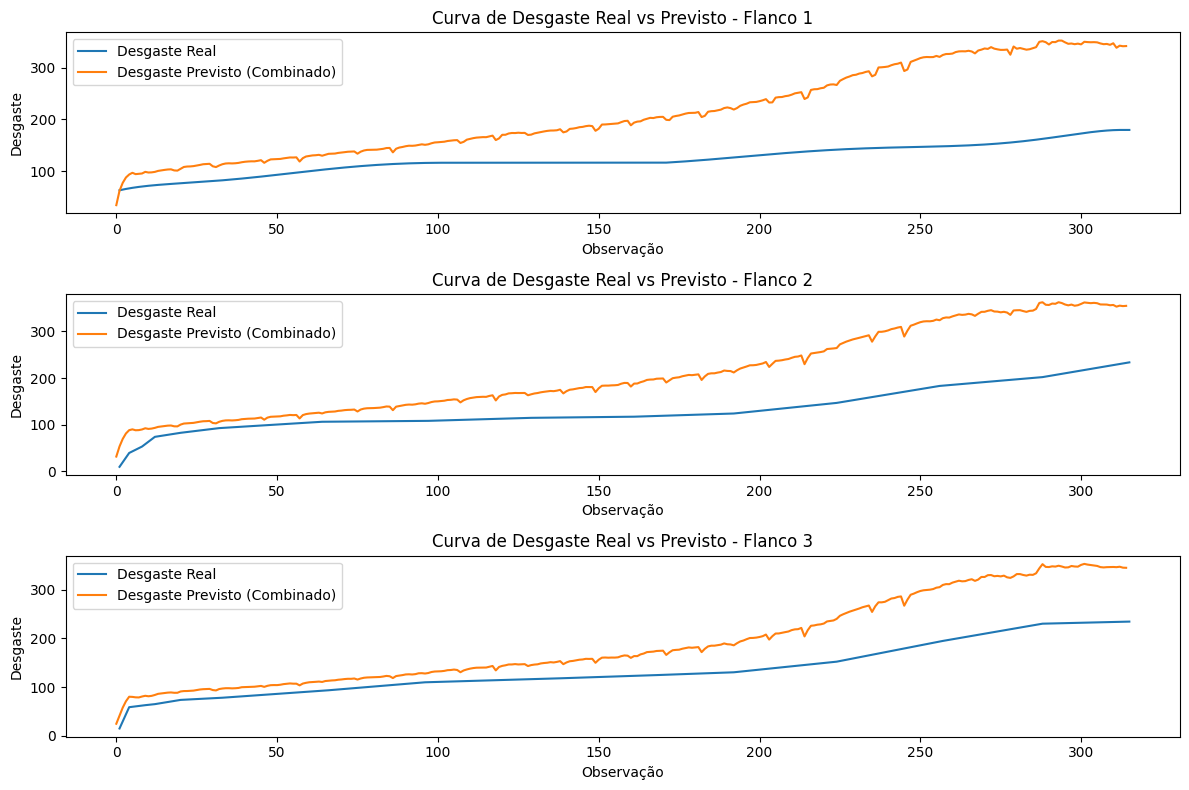

In [ ]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)')

    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Previsões nos dados de teste usando os melhores modelos
y_pred_test_C1 = grid_search_C1.best_estimator_.predict(X_test_C6)
y_pred_test_C2 = grid_search_C2.best_estimator_.predict(X_test_C6)

# Predição combinada (média das previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação final da predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

MSE Teste (Predição Combinada): [134.07, 394.91, 46.16]
MAPE Teste (Predição Combinada): [0.07, 0.12, 0.04]
R2 Teste (Predição Combinada): [0.82, 0.79, 0.98]


## SGD com 50% das features (23 features)

In [ ]:
# Passo 1: Aplicando o RFE fora do GridSearch
# Definindo o modelo base para o RFE (sem regularização)
rfe_estimator = LinearRegression()

# Selecionando o número desejado de features com RFE para C1 e C2
n_features_to_select = 23  # Defina o número de features a serem selecionadas

rfe_C1 = RFE(estimator=rfe_estimator, n_features_to_select=n_features_to_select)
X_train_C1_rfe_np = rfe_C1.fit_transform(X_train_C1, y_train_C1)

rfe_C2 = RFE(estimator=rfe_estimator, n_features_to_select=n_features_to_select)
X_train_C2_rfe_np = rfe_C2.fit_transform(X_train_C2, y_train_C2)

# Exibindo as features selecionadas
selected_features_C1 = X_train_C1.columns[rfe_C1.support_]
selected_features_C2 = X_train_C2.columns[rfe_C2.support_]
print("Features selecionadas para C1:", selected_features_C1.tolist())
print("Features selecionadas para C2:", selected_features_C2.tolist())

# Passo 2: Atualizar X_test para conter apenas as features selecionadas
X_test_C6_rfe_C1 = X_test_C6[selected_features_C1]
X_test_C6_rfe_C2 = X_test_C6[selected_features_C2]

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = pd.DataFrame(X_train_C1_rfe_np, columns=selected_features_C1, index=X_train_C1.index)
X_train_C2_rfe = pd.DataFrame(X_train_C2_rfe_np, columns=selected_features_C2, index=X_train_C2.index)

# Passo 3: Configurando o GridSearch sem o RFE interno
# Definindo os parâmetros para o GridSearchCV
param_grid = {
    'regressor__estimator__alpha': [0.001, 0.01, 0.1],  # Controle da intensidade da regularização L2
    'regressor__estimator__max_iter': [5000, 10000]
}

# Definindo o pipeline sem o RFE para cada ferramenta
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(SGDRegressor(penalty='l2', tol=1e-3, random_state=42)))  # Regularização L2 no regressor
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1
print("Performance em cada fold para o modelo C1:")
for i, (train_index, test_index) in enumerate(tscv.split(X_train_C1_rfe)):
    X_train_fold, X_test_fold = X_train_C1_rfe.iloc[train_index], X_train_C1_rfe.iloc[test_index]
    y_train_fold, y_test_fold = y_train_C1.iloc[train_index], y_train_C1.iloc[test_index]
    grid_search_C1.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = grid_search_C1.best_estimator_.predict(X_test_fold)

    mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
    r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
    mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

    print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")

# Avaliação da performance em cada fold para C2
print("Performance em cada fold para o modelo C2:")
for i, (train_index, test_index) in enumerate(tscv.split(X_train_C2_rfe)):
    X_train_fold, X_test_fold = X_train_C2_rfe.iloc[train_index], X_train_C2_rfe.iloc[test_index]
    y_train_fold, y_test_fold = y_train_C2.iloc[train_index], y_train_C2.iloc[test_index]
    grid_search_C2.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = grid_search_C2.best_estimator_.predict(X_test_fold)

    mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
    r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
    mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

    print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")


Features selecionadas para C1: ['acc_x_wavelet_energy_3000.0Hz', 'acc_x_wavelet_energy_1500.0Hz', 'acc_y_std', 'acc_y_rms', 'acc_y_spectral_skewness', 'acc_y_wavelet_energy_3000.0Hz', 'acc_y_wavelet_energy_375.0Hz', 'acc_z_std', 'acc_z_rms', 'acc_z_spectral_kurtosis', 'acc_z_spectral_skewness', 'acc_z_wavelet_energy_3000.0Hz', 'acc_z_wavelet_energy_1500.0Hz', 'acc_x_std_lag-1', 'acc_y_std_lag-1', 'acc_z_std_lag-1', 'flute_1_lag1', 'flute_2_lag1', 'flute_2_lag2', 'flute_2_lag3', 'flute_3_lag1', 'flute_3_lag2', 'flute_3_lag3']
Features selecionadas para C2: ['force_x_std', 'force_z_skewness', 'force_z_kurtosis', 'acc_x_wavelet_energy_3000.0Hz', 'acc_x_wavelet_energy_1500.0Hz', 'acc_y_std', 'acc_y_rms', 'acc_y_spectral_skewness', 'acc_y_wavelet_energy_3000.0Hz', 'acc_y_wavelet_energy_375.0Hz', 'acc_z_std', 'acc_z_rms', 'acc_z_spectral_kurtosis', 'acc_z_spectral_skewness', 'acc_z_wavelet_energy_3000.0Hz', 'acc_z_wavelet_energy_1500.0Hz', 'acc_x_std_lag-1', 'acc_y_std_lag-1', 'acc_z_std_lag

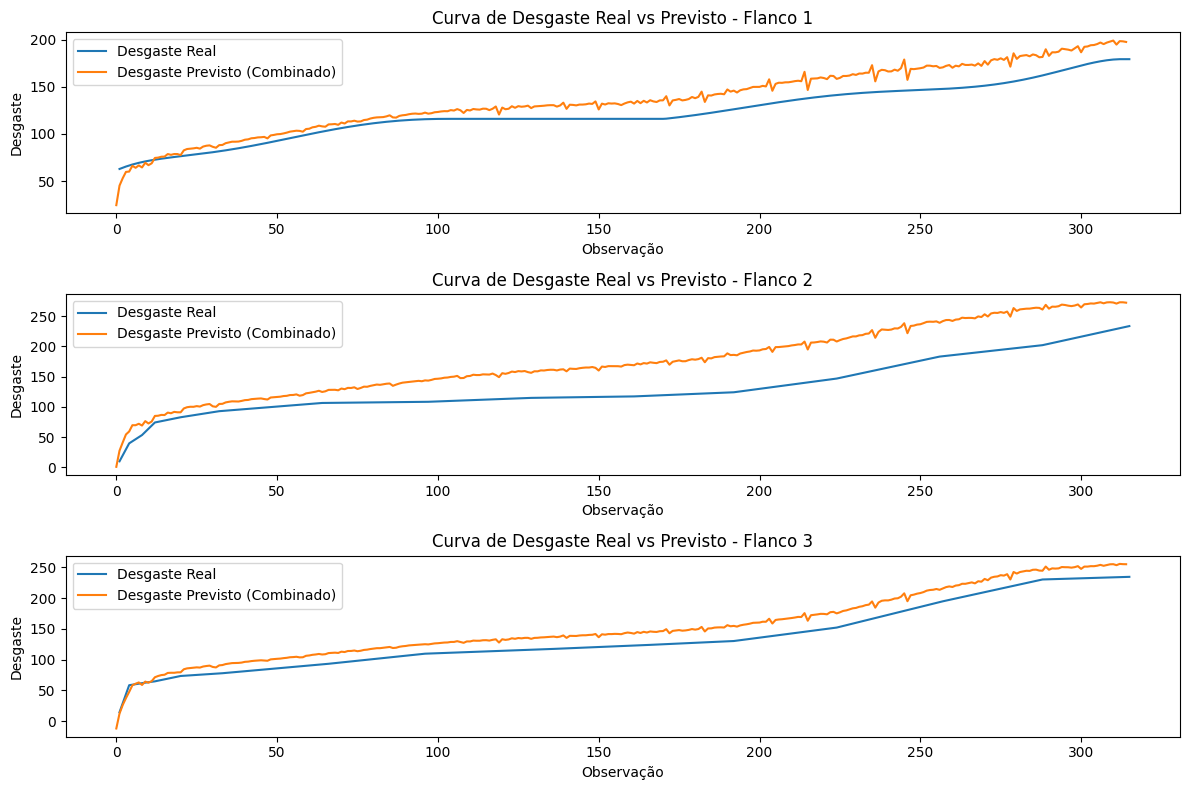

In [ ]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)')

    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

## SGD com 100% das features (45 features)

In [36]:
# Passo 1: Aplicando o RFE fora do GridSearch
# Definindo o modelo base para o RFE (sem regularização)
rfe_estimator = LinearRegression()

# Selecionando o número desejado de features com RFE para C1 e C2
n_features_to_select = 45  # Defina o número de features a serem selecionadas

rfe_C1 = RFE(estimator=rfe_estimator, n_features_to_select=n_features_to_select)
X_train_C1_rfe_np = rfe_C1.fit_transform(X_train_C1, y_train_C1)

rfe_C2 = RFE(estimator=rfe_estimator, n_features_to_select=n_features_to_select)
X_train_C2_rfe_np = rfe_C2.fit_transform(X_train_C2, y_train_C2)

# Exibindo as features selecionadas
selected_features_C1 = X_train_C1.columns[rfe_C1.support_]
selected_features_C2 = X_train_C2.columns[rfe_C2.support_]
print("Features selecionadas para C1:", selected_features_C1.tolist())
print("Features selecionadas para C2:", selected_features_C2.tolist())

# Passo 2: Atualizar X_test para conter apenas as features selecionadas
X_test_C6_rfe_C1 = X_test_C6[selected_features_C1]
X_test_C6_rfe_C2 = X_test_C6[selected_features_C2]

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = pd.DataFrame(X_train_C1_rfe_np, columns=selected_features_C1, index=X_train_C1.index)
X_train_C2_rfe = pd.DataFrame(X_train_C2_rfe_np, columns=selected_features_C2, index=X_train_C2.index)

# Passo 3: Configurando o GridSearch sem o RFE interno
# Definindo os parâmetros para o GridSearchCV
param_grid = {
    'regressor__estimator__alpha': [0.001, 0.01, 0.1],  # Controle da intensidade da regularização L2
    'regressor__estimator__max_iter': [5000, 10000]
}

# Definindo o pipeline sem o RFE para cada ferramenta
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(SGDRegressor(penalty='l2', tol=1e-3, random_state=42)))  # Regularização L2 no regressor
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1
print("Performance em cada fold para o modelo C1:")
for i, (train_index, test_index) in enumerate(tscv.split(X_train_C1_rfe)):
    X_train_fold, X_test_fold = X_train_C1_rfe.iloc[train_index], X_train_C1_rfe.iloc[test_index]
    y_train_fold, y_test_fold = y_train_C1.iloc[train_index], y_train_C1.iloc[test_index]
    grid_search_C1.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = grid_search_C1.best_estimator_.predict(X_test_fold)

    mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
    r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
    mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

    print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")

# Avaliação da performance em cada fold para C2
print("Performance em cada fold para o modelo C2:")
for i, (train_index, test_index) in enumerate(tscv.split(X_train_C2_rfe)):
    X_train_fold, X_test_fold = X_train_C2_rfe.iloc[train_index], X_train_C2_rfe.iloc[test_index]
    y_train_fold, y_test_fold = y_train_C2.iloc[train_index], y_train_C2.iloc[test_index]
    grid_search_C2.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = grid_search_C2.best_estimator_.predict(X_test_fold)

    mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
    r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
    mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

    print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")


Features selecionadas para C1: ['force_x_min', 'force_x_mean', 'force_x_std', 'force_x_kurtosis', 'force_x_spectral_kurtosis', 'force_y_max', 'force_y_std', 'force_y_spectral_kurtosis', 'force_y_spectral_skewness', 'force_z_max', 'force_z_min', 'force_z_std', 'force_z_skewness', 'force_z_kurtosis', 'acc_x_spectral_centroid', 'acc_x_spectral_kurtosis', 'acc_x_wavelet_energy_3000.0Hz', 'acc_x_wavelet_energy_1500.0Hz', 'acc_y_std', 'acc_y_rms', 'acc_y_spectral_centroid', 'acc_y_spectral_skewness', 'acc_y_wavelet_energy_3000.0Hz', 'acc_y_wavelet_energy_375.0Hz', 'acc_z_std', 'acc_z_rms', 'acc_z_spectral_kurtosis', 'acc_z_spectral_skewness', 'acc_z_wavelet_energy_3000.0Hz', 'acc_z_wavelet_energy_1500.0Hz', 'force_x_mean_lag-1', 'force_x_std_lag-1', 'force_y_std_lag-1', 'acc_x_std_lag-1', 'acc_y_std_lag-1', 'acc_z_std_lag-1', 'flute_1_lag1', 'flute_1_lag2', 'flute_1_lag3', 'flute_2_lag1', 'flute_2_lag2', 'flute_2_lag3', 'flute_3_lag1', 'flute_3_lag2', 'flute_3_lag3']
Features selecionadas pa

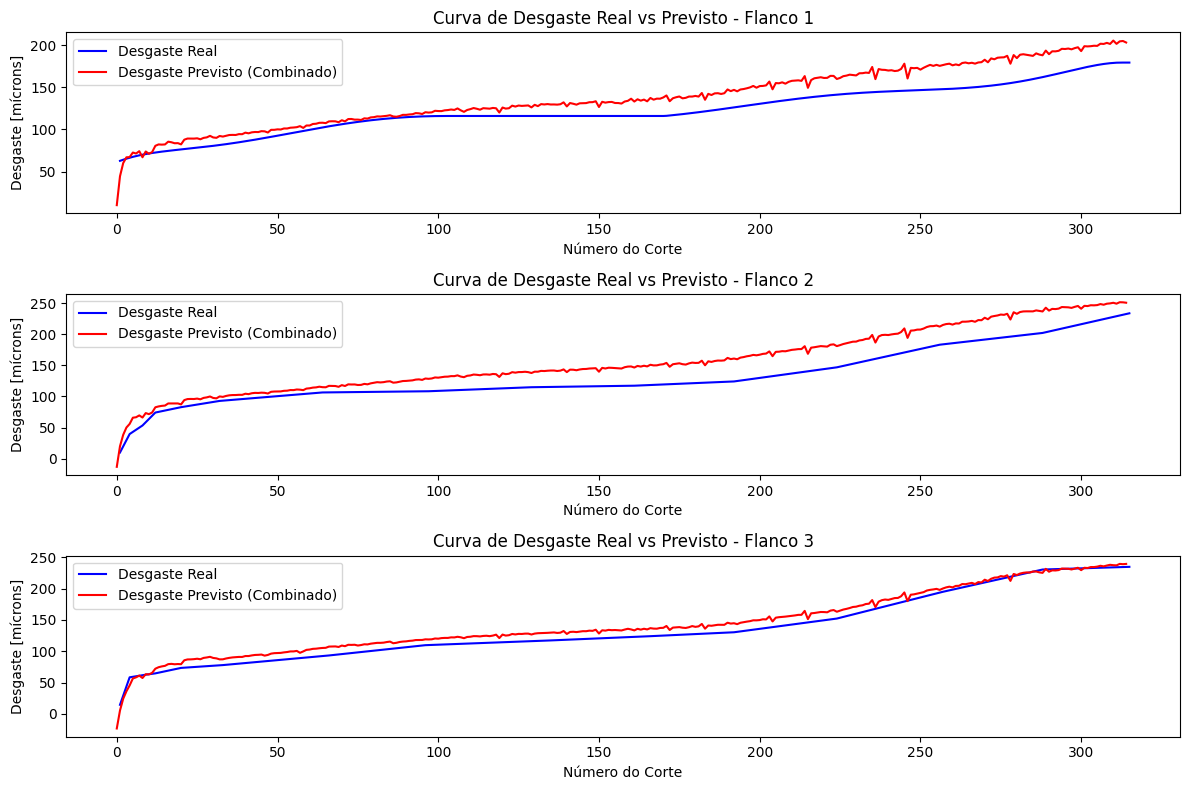

In [37]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color='blue')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color='red')

    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

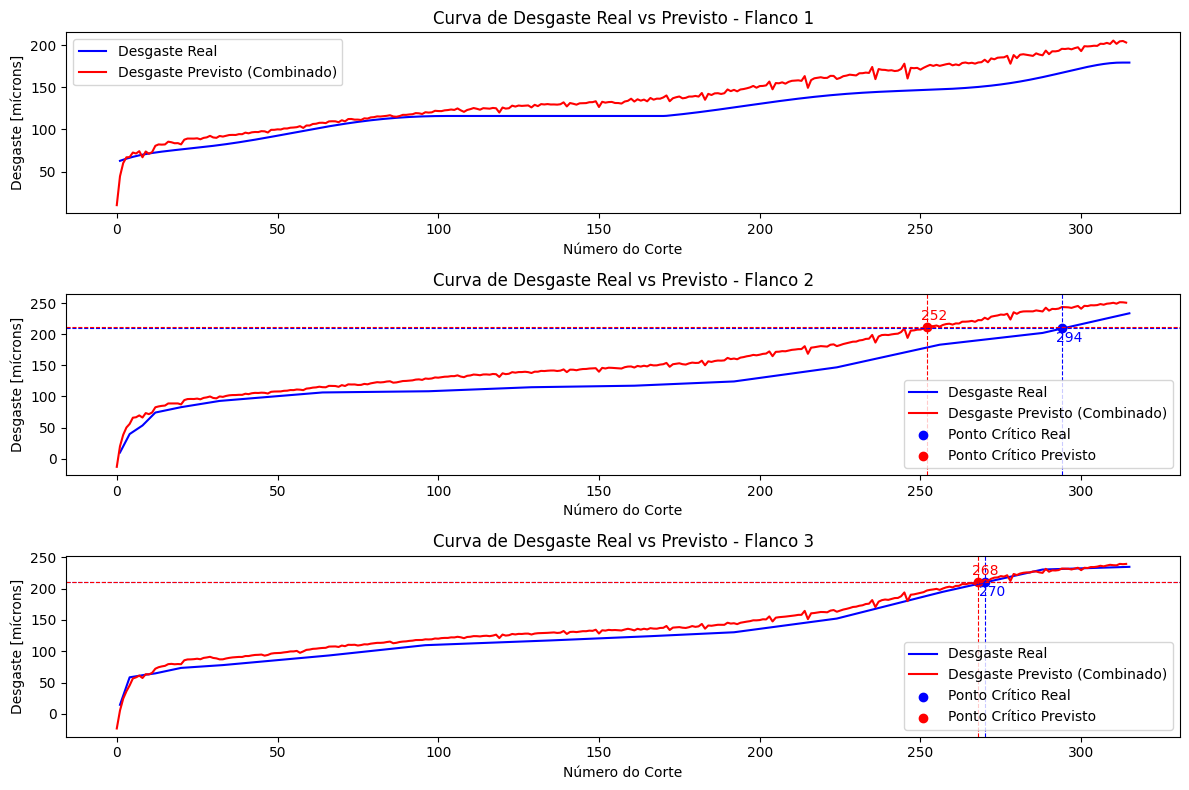

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que y_pred_test_combined e y_test_C6 já sejam definidos:
# - y_pred_test_combined: matriz numpy com previsões de desgaste (linhas = observações, colunas = flancos).
# - y_test_C6: DataFrame com valores reais de desgaste (linhas = observações, colunas = flancos).

# Define o valor crítico de desgaste
desgaste_critico = 210

# Cores para as curvas e pontos críticos
cores_pred = ['red', 'red', 'red']
cores_real = ['blue', 'blue', 'blue']

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):  # Para cada flanco (coluna)
    # Ponto crítico para o dataset de previsões (y_pred_test_combined)
    indices_criticos_pred = np.where(y_pred_test_combined[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_pred) > 0:
        indice_critico_pred = indices_criticos_pred[0]
        valor_critico_pred = y_pred_test_combined[indice_critico_pred, i]
    else:
        indice_critico_pred = 315
        valor_critico_pred = 0

    # Ponto crítico para o dataset real (y_test_C6)
    indices_criticos_real = np.where(y_test_C6.iloc[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_real) > 0:
        indice_critico_real = indices_criticos_real[0]
        valor_critico_real = y_test_C6.iloc[indice_critico_real, i]
    else:
        indice_critico_real = 315
        valor_critico_real = 0

    # Subplot para o flanco atual
    plt.subplot(3, 1, i + 1)

    # Gráficos das curvas de desgaste real e previsto
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color=cores_real[i])  # Dataset de teste (real)
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color=cores_pred[i])  # Previsões

    # Adiciona o ponto crítico para valores reais
    if indice_critico_real < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_real, valor_critico_real, color=cores_real[i], label='Ponto Crítico Real')
        plt.axhline(y=valor_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_real}",  # Texto da anotação
                     (indice_critico_real, valor_critico_real),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, -10), ha='center', color=cores_real[i])  # Posição do texto

    # Adiciona o ponto crítico para previsões
    if indice_critico_pred < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_pred, valor_critico_pred, color=cores_pred[i], label='Ponto Crítico Previsto')
        plt.axhline(y=valor_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_pred}",  # Texto da anotação
                     (indice_critico_pred, valor_critico_pred),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, 5), ha='center', color=cores_pred[i])  # Posição do texto

    # Personalização do gráfico
    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## Features de tempo

In [59]:
temporal_features = ['force_x_min', 'force_x_mean', 'force_x_std', 'force_x_kurtosis', 'force_y_max', 'force_y_std', 'force_z_max',
       'force_z_min', 'force_z_std', 'force_z_skewness', 'force_z_kurtosis',
       'acc_y_std', 'acc_y_rms', 'acc_z_std', 'acc_z_rms', 'force_x_mean_lag-1', 'force_x_std_lag-1', 'force_y_std_lag-1',
       'acc_x_std_lag-1', 'acc_y_std_lag-1', 'acc_z_std_lag-1', 'flute_1_lag1',
       'flute_1_lag2', 'flute_1_lag3', 'flute_2_lag1', 'flute_2_lag2',
       'flute_2_lag3', 'flute_3_lag1', 'flute_3_lag2', 'flute_3_lag3']

In [60]:
selected_features = temporal_features

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = X_train_C1[selected_features]
X_train_C2_rfe = X_train_C2[selected_features]
X_test_C6_rfe_C1 = X_test_C6[selected_features]
X_test_C6_rfe_C2 = X_test_C6[selected_features]

# Passo 3: Configurando o GridSearch sem o RFE interno
# Definindo os parâmetros para o GridSearchCV
param_grid = {
    'regressor__estimator__alpha': [0.001, 0.01, 0.1],  # Controle da intensidade da regularização L2
    'regressor__estimator__max_iter': [5000, 10000]
}

# Definindo o pipeline sem o RFE para cada ferramenta
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(SGDRegressor(penalty='l2', tol=1e-3, random_state=42)))  # Regularização L2 no regressor
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1
print("Performance em cada fold para o modelo C1:")
for i, (train_index, test_index) in enumerate(tscv.split(X_train_C1_rfe)):
    X_train_fold, X_test_fold = X_train_C1_rfe.iloc[train_index], X_train_C1_rfe.iloc[test_index]
    y_train_fold, y_test_fold = y_train_C1.iloc[train_index], y_train_C1.iloc[test_index]
    grid_search_C1.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = grid_search_C1.best_estimator_.predict(X_test_fold)

    mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
    r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
    mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

    print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")

# Avaliação da performance em cada fold para C2
print("Performance em cada fold para o modelo C2:")
for i, (train_index, test_index) in enumerate(tscv.split(X_train_C2_rfe)):
    X_train_fold, X_test_fold = X_train_C2_rfe.iloc[train_index], X_train_C2_rfe.iloc[test_index]
    y_train_fold, y_test_fold = y_train_C2.iloc[train_index], y_train_C2.iloc[test_index]
    grid_search_C2.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = grid_search_C2.best_estimator_.predict(X_test_fold)

    mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
    r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
    mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

    print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")

Treinando o modelo para C1 com validação cruzada...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=10000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=10000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=10000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=10000; tot

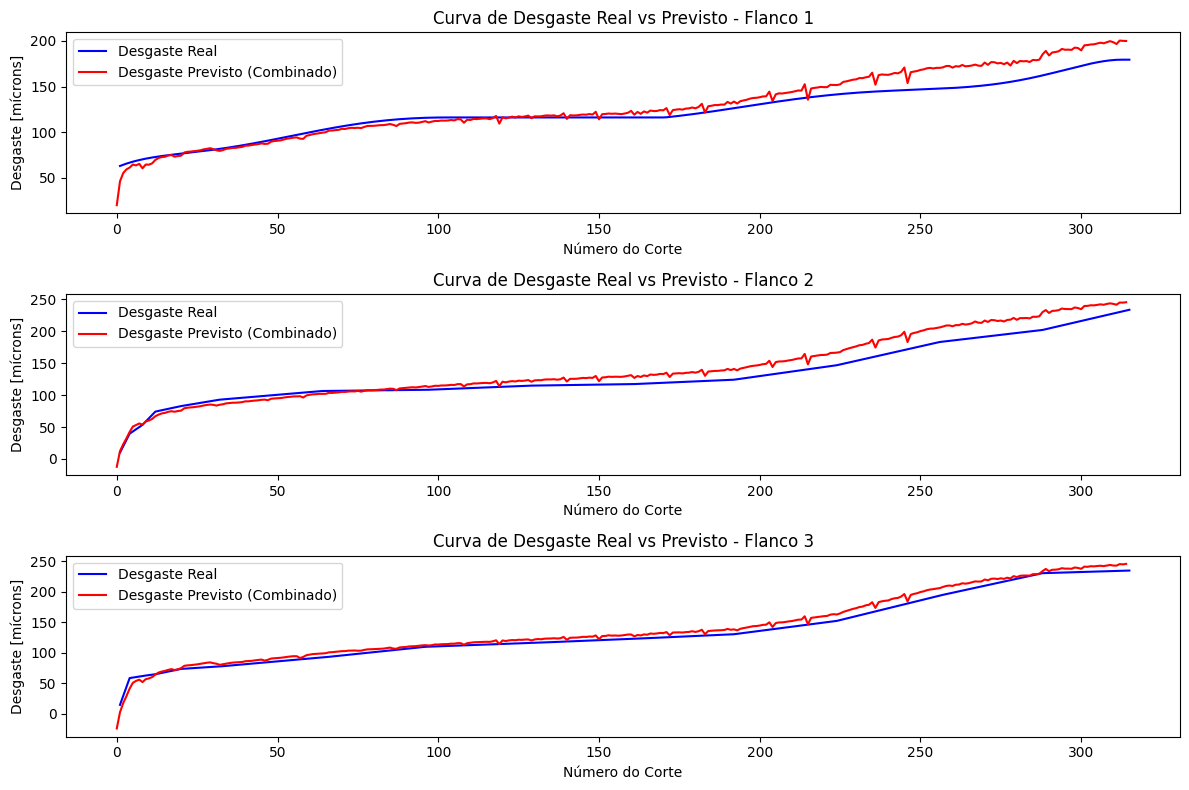

In [61]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color='blue')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color='red')

    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

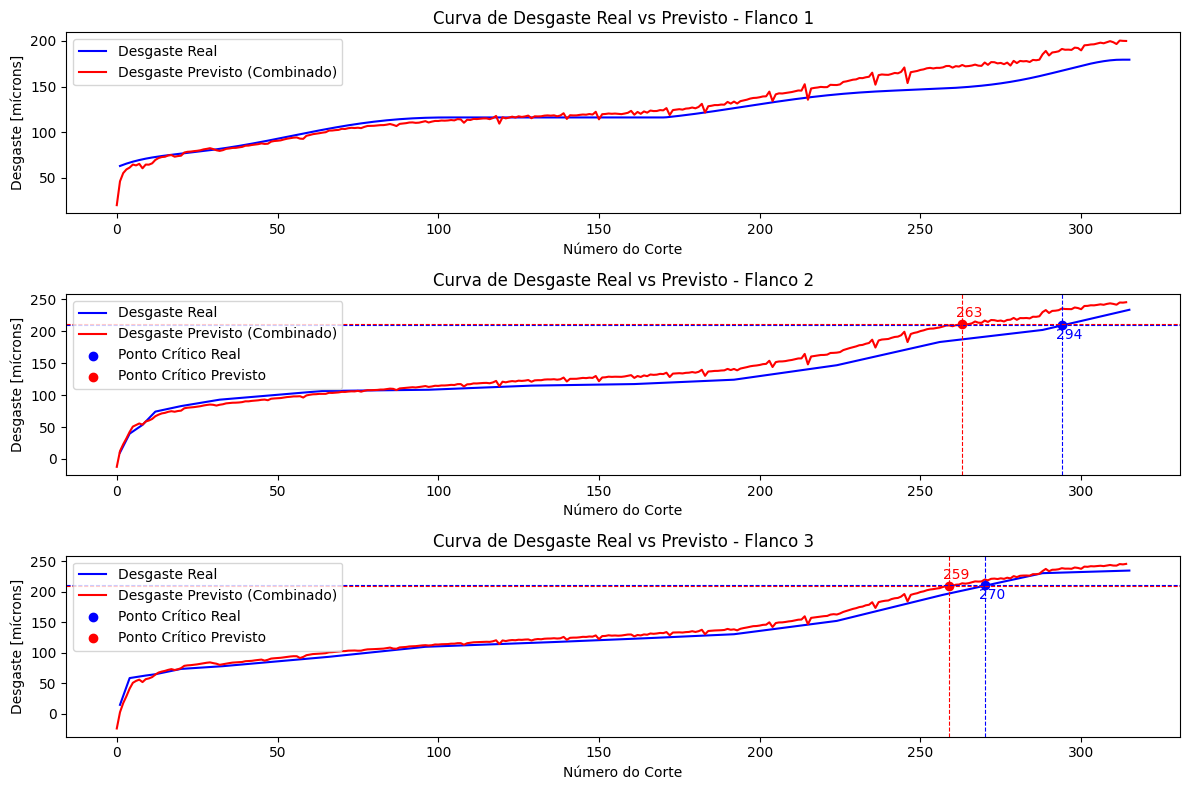

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que y_pred_test_combined e y_test_C6 já sejam definidos:
# - y_pred_test_combined: matriz numpy com previsões de desgaste (linhas = observações, colunas = flancos).
# - y_test_C6: DataFrame com valores reais de desgaste (linhas = observações, colunas = flancos).

# Define o valor crítico de desgaste
desgaste_critico = 210

# Cores para as curvas e pontos críticos
cores_pred = ['red', 'red', 'red']
cores_real = ['blue', 'blue', 'blue']

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):  # Para cada flanco (coluna)
    # Ponto crítico para o dataset de previsões (y_pred_test_combined)
    indices_criticos_pred = np.where(y_pred_test_combined[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_pred) > 0:
        indice_critico_pred = indices_criticos_pred[0]
        valor_critico_pred = y_pred_test_combined[indice_critico_pred, i]
    else:
        indice_critico_pred = 315
        valor_critico_pred = 0

    # Ponto crítico para o dataset real (y_test_C6)
    indices_criticos_real = np.where(y_test_C6.iloc[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_real) > 0:
        indice_critico_real = indices_criticos_real[0]
        valor_critico_real = y_test_C6.iloc[indice_critico_real, i]
    else:
        indice_critico_real = 315
        valor_critico_real = 0

    # Subplot para o flanco atual
    plt.subplot(3, 1, i + 1)

    # Gráficos das curvas de desgaste real e previsto
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color=cores_real[i])  # Dataset de teste (real)
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color=cores_pred[i])  # Previsões

    # Adiciona o ponto crítico para valores reais
    if indice_critico_real < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_real, valor_critico_real, color=cores_real[i], label='Ponto Crítico Real')
        plt.axhline(y=valor_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_real}",  # Texto da anotação
                     (indice_critico_real, valor_critico_real),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, -10), ha='center', color=cores_real[i])  # Posição do texto

    # Adiciona o ponto crítico para previsões
    if indice_critico_pred < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_pred, valor_critico_pred, color=cores_pred[i], label='Ponto Crítico Previsto')
        plt.axhline(y=valor_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_pred}",  # Texto da anotação
                     (indice_critico_pred, valor_critico_pred),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, 5), ha='center', color=cores_pred[i])  # Posição do texto

    # Personalização do gráfico
    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## Features de frequência

In [67]:
spectral_features = ['force_x_spectral_kurtosis',
       'force_y_spectral_kurtosis', 'force_y_spectral_skewness',
       'acc_x_spectral_centroid', 'acc_x_spectral_kurtosis',
       'acc_x_wavelet_energy_3000.0Hz', 'acc_x_wavelet_energy_1500.0Hz', 'acc_y_spectral_centroid',
       'acc_y_spectral_skewness', 'acc_y_wavelet_energy_3000.0Hz',
       'acc_y_wavelet_energy_375.0Hz',
       'acc_z_spectral_kurtosis', 'acc_z_spectral_skewness',
       'acc_z_wavelet_energy_3000.0Hz', 'acc_z_wavelet_energy_1500.0Hz', 'flute_1_lag1',
       'flute_1_lag2', 'flute_1_lag3', 'flute_2_lag1', 'flute_2_lag2',
       'flute_2_lag3', 'flute_3_lag1', 'flute_3_lag2', 'flute_3_lag3']

In [68]:
selected_features = spectral_features

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = X_train_C1[selected_features]
X_train_C2_rfe = X_train_C2[selected_features]
X_test_C6_rfe_C1 = X_test_C6[selected_features]
X_test_C6_rfe_C2 = X_test_C6[selected_features]

# Passo 3: Configurando o GridSearch sem o RFE interno
# Definindo os parâmetros para o GridSearchCV
param_grid = {
    'regressor__estimator__alpha': [0.001, 0.01, 0.1],  # Controle da intensidade da regularização L2
    'regressor__estimator__max_iter': [5000, 10000]
}

# Definindo o pipeline sem o RFE para cada ferramenta
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(SGDRegressor(penalty='l2', tol=1e-3, random_state=42)))  # Regularização L2 no regressor
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1
print("Performance em cada fold para o modelo C1:")
mse_folds_C1, r2_folds_C1, mape_folds_C1 = [], [], []
for i, (train_index, test_index) in enumerate(tscv.split(X_train_C1_rfe)):
    X_train_fold, X_test_fold = X_train_C1_rfe.iloc[train_index], X_train_C1_rfe.iloc[test_index]
    y_train_fold, y_test_fold = y_train_C1.iloc[train_index], y_train_C1.iloc[test_index]
    grid_search_C1.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = grid_search_C1.best_estimator_.predict(X_test_fold)

    mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
    r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
    mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

    mse_folds_C1.append(mse_fold)
    r2_folds_C1.append(r2_fold)
    mape_folds_C1.append(mape_fold)

    print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")

# Calculando médias para C1
mean_mse_C1 = np.mean(mse_folds_C1, axis=0)
mean_r2_C1 = np.mean(r2_folds_C1, axis=0)
mean_mape_C1 = np.mean(mape_folds_C1, axis=0)
print(f"Médias para C1 - MSE: {mean_mse_C1}, R2: {mean_r2_C1}, MAPE: {mean_mape_C1}")

# Avaliação da performance em cada fold para C2
print("Performance em cada fold para o modelo C2:")
mse_folds_C2, r2_folds_C2, mape_folds_C2 = [], [], []
for i, (train_index, test_index) in enumerate(tscv.split(X_train_C2_rfe)):
    X_train_fold, X_test_fold = X_train_C2_rfe.iloc[train_index], X_train_C2_rfe.iloc[test_index]
    y_train_fold, y_test_fold = y_train_C2.iloc[train_index], y_train_C2.iloc[test_index]
    grid_search_C2.best_estimator_.fit(X_train_fold, y_train_fold)
    y_pred_fold = grid_search_C2.best_estimator_.predict(X_test_fold)

    mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
    r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
    mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

    mse_folds_C2.append(mse_fold)
    r2_folds_C2.append(r2_fold)
    mape_folds_C2.append(mape_fold)

    print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")

# Calculando médias para C2
mean_mse_C2 = np.mean(mse_folds_C2, axis=0)
mean_r2_C2 = np.mean(r2_folds_C2, axis=0)
mean_mape_C2 = np.mean(mape_folds_C2, axis=0)
print(f"Médias para C2 - MSE: {mean_mse_C2}, R2: {mean_r2_C2}, MAPE: {mean_mape_C2}")

Treinando o modelo para C1 com validação cruzada...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=5000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=10000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=10000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=10000; total time=   0.0s
[CV] END regressor__estimator__alpha=0.001, regressor__estimator__max_iter=10000; tot

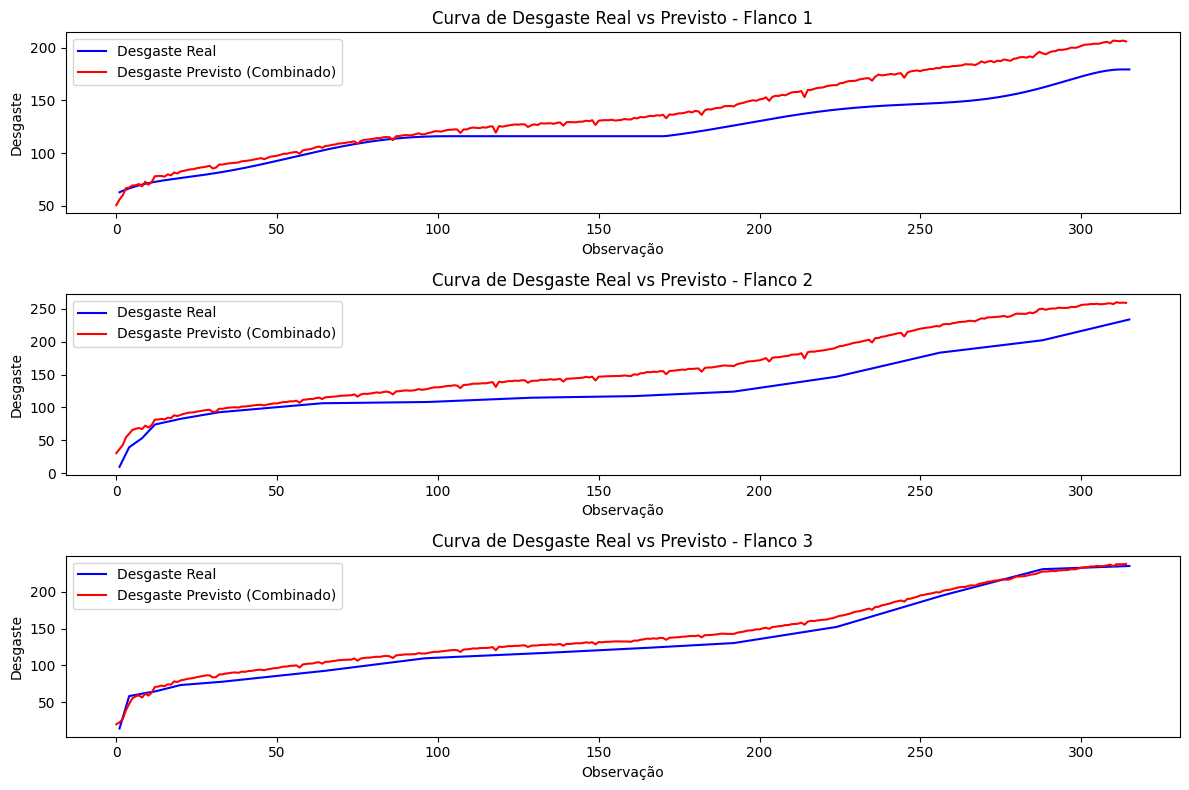

In [69]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color='blue')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color='red')

    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

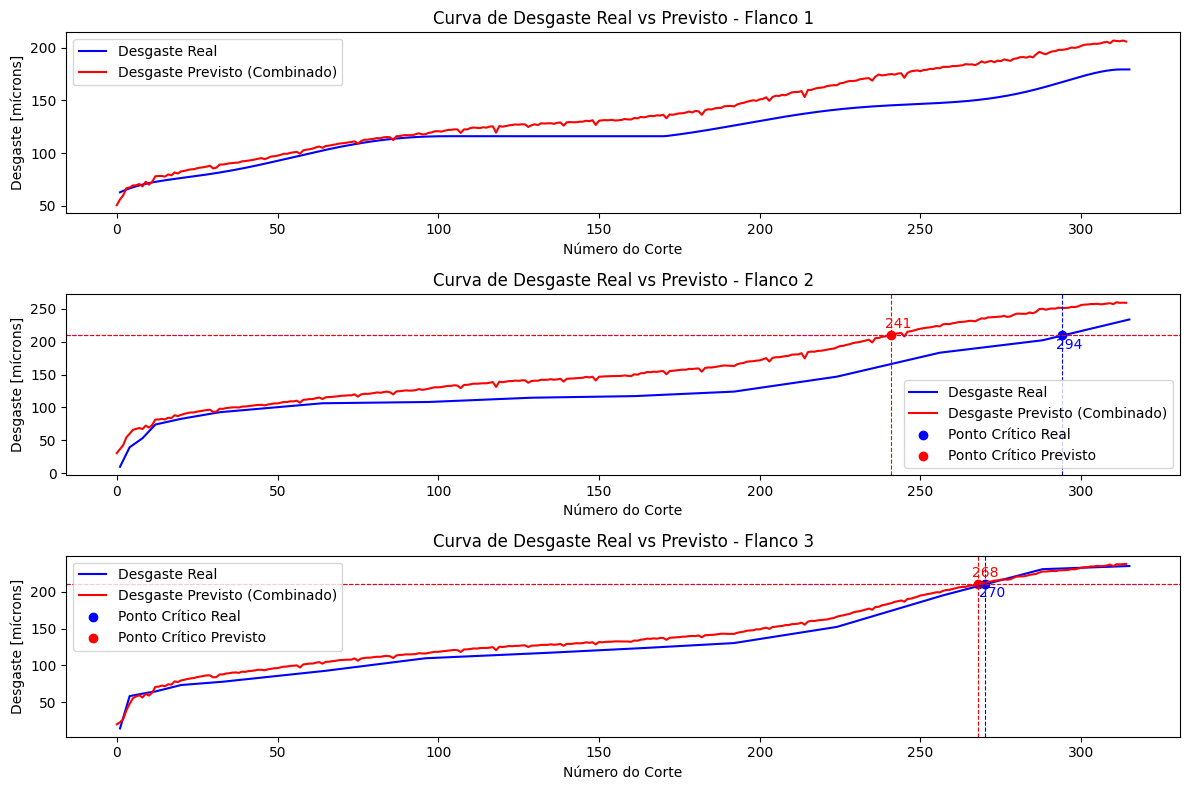

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que y_pred_test_combined e y_test_C6 já sejam definidos:
# - y_pred_test_combined: matriz numpy com previsões de desgaste (linhas = observações, colunas = flancos).
# - y_test_C6: DataFrame com valores reais de desgaste (linhas = observações, colunas = flancos).

# Define o valor crítico de desgaste
desgaste_critico = 210

# Cores para as curvas e pontos críticos
cores_pred = ['red', 'red', 'red']
cores_real = ['blue', 'blue', 'blue']

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):  # Para cada flanco (coluna)
    # Ponto crítico para o dataset de previsões (y_pred_test_combined)
    indices_criticos_pred = np.where(y_pred_test_combined[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_pred) > 0:
        indice_critico_pred = indices_criticos_pred[0]
        valor_critico_pred = y_pred_test_combined[indice_critico_pred, i]
    else:
        indice_critico_pred = 315
        valor_critico_pred = 0

    # Ponto crítico para o dataset real (y_test_C6)
    indices_criticos_real = np.where(y_test_C6.iloc[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_real) > 0:
        indice_critico_real = indices_criticos_real[0]
        valor_critico_real = y_test_C6.iloc[indice_critico_real, i]
    else:
        indice_critico_real = 315
        valor_critico_real = 0

    # Subplot para o flanco atual
    plt.subplot(3, 1, i + 1)

    # Gráficos das curvas de desgaste real e previsto
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color=cores_real[i])  # Dataset de teste (real)
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color=cores_pred[i])  # Previsões

    # Adiciona o ponto crítico para valores reais
    if indice_critico_real < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_real, valor_critico_real, color=cores_real[i], label='Ponto Crítico Real')
        plt.axhline(y=valor_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_real}",  # Texto da anotação
                     (indice_critico_real, valor_critico_real),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, -10), ha='center', color=cores_real[i])  # Posição do texto

    # Adiciona o ponto crítico para previsões
    if indice_critico_pred < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_pred, valor_critico_pred, color=cores_pred[i], label='Ponto Crítico Previsto')
        plt.axhline(y=valor_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_pred}",  # Texto da anotação
                     (indice_critico_pred, valor_critico_pred),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, 5), ha='center', color=cores_pred[i])  # Posição do texto

    # Personalização do gráfico
    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()